# Skin Cancer Classification using ISIC 2019 Dataset
This notebook explores the ISIC 2019 dataset to classify different types of skin cancer. The workflow includes:
- **Data exploration and preprocessing**
- **Feature extraction using ResNet50**
- **Training multiple ML models**
- **Comparing performance using accuracy & confusion matrix**
- **Implementing a sample prediction system**

## Dataset Overview
The ISIC 2019 dataset contains images of skin lesions categorized into different skin cancer types. We will analyze and classify these images using  machine learning models.
The data contained 25000 images of skin lesions classified with 9 following classes ranging from benign to malignant skin cancer:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.



# 📂 Load and Explore Dataset
We will load:
- **Metadata file**: Contains information about images.
- **Ground truth labels**: Multi-class classification labels.
- **Image files**: Actual skin lesion images.


In [1]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
#import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.utils import resample


Metadata Sample:


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male



Ground Truth Sample:


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


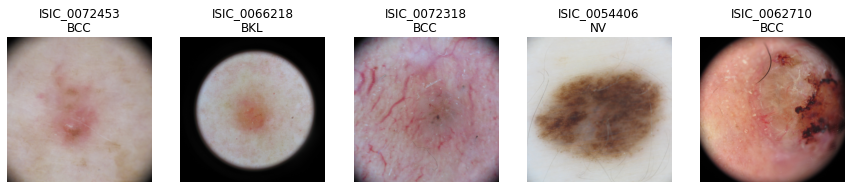

In [2]:
metadata_path = "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv"
groundtruth_path = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
metadata_df = pd.read_csv(metadata_path)
groundtruth_df = pd.read_csv(groundtruth_path)

print("Metadata Sample:")
display(metadata_df.head())

print("\nGround Truth Sample:")
display(groundtruth_df.head())

def display_sample_images(image_list, image_dir, groundtruth_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, img_name + ".jpg")

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_name}.jpg not found!")
            axes[i].set_title("Image Not Found")
            axes[i].axis("off")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error: Failed to load {img_name}.jpg")
            axes[i].set_title("Load Error")
            axes[i].axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        row = groundtruth_df[groundtruth_df['image'] == img_name].iloc[:, 1:]
        cancer_type = row.columns[row.values.argmax()]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{img_name}\n{cancer_type}")

    plt.show()

sample_images = groundtruth_df.sample(5)['image'].values
display_sample_images(sample_images, image_dir, groundtruth_df)


# 📊 Class Distribution
We will visualize the class distribution to understand the imbalance in the dataset.

The graph shows the class distribution of images in the ISIC 2019 dataset, which is used for skin cancer classification. The x-axis represents different types of skin cancer or lesions, while the y-axis shows the number of images corresponding to each category.

Here's a breakdown of the categories and the number of images for each:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.
  
In summary, the dataset is heavily imbalanced, with the "NV" category having significantly more images compared to the other categories. This imbalance might need to be addressed when training machine learning models for skin cancer classification.


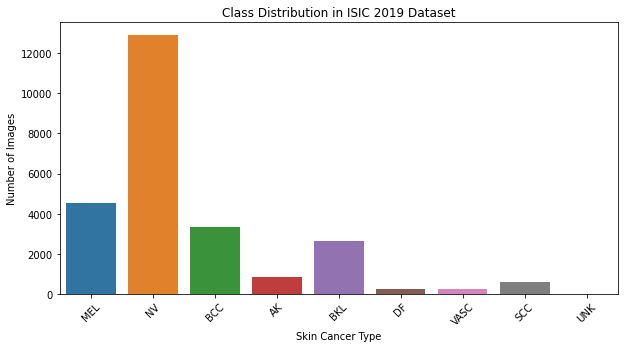

In [3]:
class_counts = groundtruth_df.iloc[:, 1:].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in ISIC 2019 Dataset")
plt.show()


# ⚖️ Handling Class Imbalance in ISIC 2019 Dataset
The dataset is highly **imbalanced**, with some classes containing significantly more images than others. Training a model on an imbalanced dataset can lead to biased predictions.

### 🛠 Methods to Balance Data:
1. **Undersampling**: Reducing the number of samples in the majority class.
2. **Oversampling**: Duplicating samples from minority classes.


Since **undersampling** removes valuable data, we will use **oversampling** by duplicating images from underrepresented classes to match the majority class.


Skipping class 'UNK' because it has no samples.
Balanced Class Distribution:
 MEL     12875.0
NV      12875.0
BCC     12875.0
AK      12875.0
BKL     12875.0
DF      12875.0
VASC    12875.0
SCC     12875.0
UNK         0.0
dtype: float64


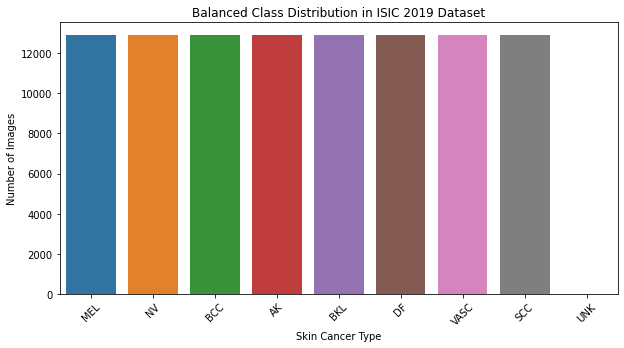

In [4]:
balanced_data = []

max_count = int(groundtruth_df.iloc[:, 1:].sum().max())

for class_name in groundtruth_df.columns[1:]:
    class_subset = groundtruth_df[groundtruth_df[class_name] == 1]

    if len(class_subset) == 0:
        print(f"Skipping class '{class_name}' because it has no samples.")
        continue

    class_upsampled = resample(class_subset, replace=True, n_samples=max_count, random_state=42)

    balanced_data.append(class_upsampled)

balanced_groundtruth_df = pd.concat(balanced_data)

balanced_groundtruth_df = balanced_groundtruth_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_class_counts = balanced_groundtruth_df.iloc[:, 1:].sum()
print("Balanced Class Distribution:\n", balanced_class_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=balanced_class_counts.index, y=balanced_class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Balanced Class Distribution in ISIC 2019 Dataset")
plt.show()


*After doing oversampling of minority class we can see from above grpah that all classes have equal representation in the data now*

# 🔍 Feature Extraction using ResNet50
We will extract **deep learning embeddings** using a pre-trained **ResNet50** model.


In [5]:
#code prompt: Write a Python script that preprocesses images from a directory,
#loads a pretrained ResNet50 model, and modifies it to output 512D embeddings instead of the default 2048D.
#The script should extract embeddings for each image, store the results in a DataFrame, and save the embeddings along with image names to a CSV file.
#Use a progress bar to track the scanning of image files and extraction of embeddings.

image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Load Pretrained Model (ResNet50) and Modify to Output 512D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Modify model to output **512D embeddings** instead of 2048D
model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Ensure fixed-size pooling
model.fc = torch.nn.Linear(2048, 512)  # Map 2048 → 512

#  Move to GPU and set to evaluation mode
model = model.to(device)
model.eval()

#  Extract Features with Progress Bar
data = []
image_files = []

#  Expanded loop for selecting image files
for file in tqdm(os.listdir(image_dir), desc="Scanning Files", unit="file"):
    if file.endswith(".jpg") or file.endswith(".png"):
        image_files.append(file)  # Store valid image files

#  Process images and extract embeddings
embeddings = []
image_names = []

for img_file in tqdm(image_files ,desc="Extracting Embeddings", unit="image"):
    img_path = os.path.join(image_dir, img_file)

    # Load and preprocess image
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Extract embedding
    with torch.no_grad():
        embedding = model(image).cpu().numpy().flatten()  # Now 512D

    # Store image name and embedding separately
    image_names.append(os.path.splitext(img_file)[0])  # Store name without extension
    embeddings.append(embedding)  # Store embedding as list

#  Convert to DataFrame (Expanded Format)
df = pd.DataFrame(embeddings)  # Convert list of embeddings to DataFrame
df.columns = [str(i) for i in range(512)]  # Rename columns 0, 1, 2, ..., 511
df.insert(0, "image_name", image_names)  # Add image_name as the first column

df.to_csv("image_embeddings_expanded.csv", index=False)

print("✅ Embeddings extracted and saved to image_embeddings_expanded.csv")

Extracting Embeddings: 100%|██████████| 25331/25331 [14:10<00:00, 29.78image/s]


✅ Embeddings extracted and saved to image_embeddings_expanded.csv


In [6]:
#pd.read_csv('/kaggle/input/image-embeddings-resnet/image_embeddings_expanded (1).csv')
pd.read_csv('/kaggle/working/image_embeddings_expanded.csv')


,image_name,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,ISIC_0057312,-0.767601,0.329240,-0.427492,-0.386139,0.167684,-0.443814,0.401640,0.651599,0.318509,...,0.107880,0.059015,-0.599604,0.449669,0.205494,-0.020589,-0.641941,-0.281644,-0.228000,-0.190082
1,ISIC_0014233_downsampled,-1.219941,-0.451333,-0.398128,-0.096876,-0.134257,-0.519218,0.297843,0.177251,0.208782,...,-0.434482,-0.331097,-0.325077,0.173115,0.134922,0.454958,-0.475207,-0.453872,-0.557574,-0.217988
2,ISIC_0059626,-0.879956,0.027122,-0.493576,-0.074472,0.185506,-0.397003,0.352234,0.771557,0.325546,...,0.032877,-0.133459,0.071326,0.320800,0.116427,-0.074088,-0.339855,-0.137251,-0.535862,-0.270189
3,ISIC_0056156,-0.922301,0.086712,-0.149752,-0.117982,0.164410,-0.677501,0.609405,0.325846,0.138391,...,-0.213563,-0.451510,-0.498069,0.097302,-0.096654,0.361334,-0.440760,-0.261601,-0.652165,-0.148854
4,ISIC_0030912,-1.119443,0.283435,-0.001585,-0.255511,0.050944,-0.712817,0.688166,0.234974,0.360022,...,0.156722,-0.267838,-0.608507,-0.226544,-0.129064,0.626236,-0.117518,-0.101944,-0.784669,-0.297935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0010257,-0.495260,0.198948,0.243871,0.137925,0.048290,-0.448161,0.454958,0.351905,0.016956,...,0.191700,-0.260047,-0.468038,0.088794,0.067564,0.412304,-0.409727,-0.317410,-0.544566,-0.302263
25327,ISIC_0012539_downsampled,-1.035764,-0.273959,-0.621943,-0.343656,-0.164536,-0.620435,0.291618,0.395353,0.362948,...,-0.035713,-0.388681,-0.312558,0.068599,0.131736,0.241564,-0.214080,-0.245603,-0.779187,-0.301571
25328,ISIC_0026236,-0.965705,0.267663,0.127081,-0.272822,-0.218131,-0.838702,0.548839,0.399387,0.173920,...,-0.006843,-0.276298,-0.579276,-0.187860,-0.058356,0.346959,-0.267365,-0.132384,-0.522629,-0.128029
25329,ISIC_0030344,-0.770994,-0.050409,-0.220785,0.098611,0.147756,-0.535444,0.501506,0.252849,0.194914,...,0.123071,-0.329943,-0.396688,-0.300788,0.112152,0.099124,-0.104741,-0.297472,-0.411299,-0.458470


Embeddings extracted from ResNet models are high-dimensional vectors representing an image's features after passing through the network. These embeddings capture essential patterns and structures, condensing the image into a fixed-size vector. They are useful for tasks like image similarity, retrieval, and transfer learning.

# Merging ISIC 2019 Dataset: Ground Truth, Embeddings, and Metadata

## **Overview**
This script merges three datasets related to the **ISIC 2019 skin lesion classification challenge**:
1. **Ground Truth Labels** (`ISIC_2019_Training_GroundTruth.csv`)
2. **Extracted Image Embeddings** (`image_embeddings_expanded.csv`)
3. **Metadata Information** (`ISIC_2019_Training_Metadata.csv`)

In [9]:
df_gt = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
df_emb = pd.read_csv('/kaggle/working/image_embeddings_expanded.csv')
df_meta = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv')
df_emb.rename(columns={"image_name": "image"}, inplace=True)

#  Perform INNER JOIN on 'image' across all DataFrames
df_merged = df_gt.merge(df_emb, on="image", how="inner").merge(df_meta, on="image", how="inner")
df_merged.to_csv("/kaggle/working/isic_2019_merged.csv", index=False)

print("✅ Merging complete! Saved as isic_2019_merged.csv")

✅ Merging complete! Saved as isic_2019_merged.csv


In [10]:
#df = pd.read_csv('/kaggle/input/isic-merged/isic_2019_merged.csv')
df = pd.read_csv('/kaggle/working/isic_2019_merged.csv')

df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (524) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,...,506,507,508,509,510,511,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292642,0.376869,-0.179327,-0.716911,-0.296275,0.601472,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020276,0.412112,-0.077253,-0.350820,-0.703422,0.289848,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.380842,0.384387,-0.700649,-0.432436,-0.303175,0.076855,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.088890,0.166121,0.030726,-0.825342,-0.441451,0.409481,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.242421,0.233716,-0.713615,-0.594567,-0.259895,0.215761,80.0,posterior torso,NaN,male


# ISIC 2019 Data Preprocessing

## **Overview**
This script processes the **ISIC 2019 dataset** and prepares it for machine learning models. It includes:
# Data cleaning & preprocessing
- Drop Unnecessary Columns
- Handle Missing Values in 'sex' Column
- One-Hot Encoding for 'anatom_site_general' Column
- Convert One-Hot Encoded Labels to Single Target Class
- Handle Missing Values in Features (X)
- Standardize Features

In [11]:
file_path = "/kaggle/working/isic_2019_merged.csv"

df = pd.read_csv(file_path, low_memory=False)

df = df.drop(columns=['image', 'lesion_id'])

df['sex'] = df['sex'].fillna('unknown')
encoder = LabelEncoder()
df['sex'] = encoder.fit_transform(df['sex'])

df = pd.get_dummies(df, columns=['anatom_site_general'], drop_first=True)

X = df.drop(df.columns[:9], axis=1)
Y = df.iloc[:, :9]
print(Y)

Y = Y.idxmax(axis=1)

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


       MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 9 columns]


### Logistic Regression Model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ge: 0.00531891
Epoch 1887, change: 0.00671481
Epoch 1888, change: 0.00742994
Epoch 1889, change: 0.00982209
Epoch 1890, change: 0.00481076
Epoch 1891, change: 0.00598498
Epoch 1892, change: 0.00805403
Epoch 1893, change: 0.00872438
Epoch 1894, change: 0.01410265
Epoch 1895, change: 0.01594838
Epoch 1896, change: 0.00865169
Epoch 1897, change: 0.00874284
Epoch 1898, change: 0.00719277
Epoch 1899, change: 0.00809360
Epoch 1900, change: 0.00902070
Epoch 1901, change: 0.01164738
Epoch 1902, change: 0.00937757
Epoch 1903, change: 0.00917226
Epoch 1904, change: 0.00696173
Epoch 1905, change: 0.00904714
Epoch 1906, change: 0.00873674
Epoch 1907, change: 0.00920382
Epoch 1908, change: 0.00840986
Epoch 1909, change: 0.00854573
Epoch 1910, change: 0.00930629
Epoch 1911, change: 0.00686878
Epoch 1912, change: 0.00808111
Epoch 1913, change: 0.01177278
Epoch 1914, change: 0.01123643
Epoch 1915, change: 0.00928338
Epoch 1916, change: 0.00888880
Epoch 1917, change: 0.00973629
Epoch 1918, change: 0.00

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.8min finished


              precision    recall  f1-score   support

          AK     0.2908    0.5028    0.3685       177
         BCC     0.6261    0.5623    0.5925       658
         BKL     0.3991    0.5168    0.4504       536
          DF     0.1949    0.4792    0.2771        48
         MEL     0.5706    0.5694    0.5700       915
          NV     0.8990    0.7320    0.8070      2567
         SCC     0.2205    0.5577    0.3161       104
        VASC     0.4891    0.7258    0.5844        62

    accuracy                         0.6438      5067
   macro avg     0.4613    0.5807    0.4957      5067
weighted avg     0.7046    0.6438    0.6655      5067



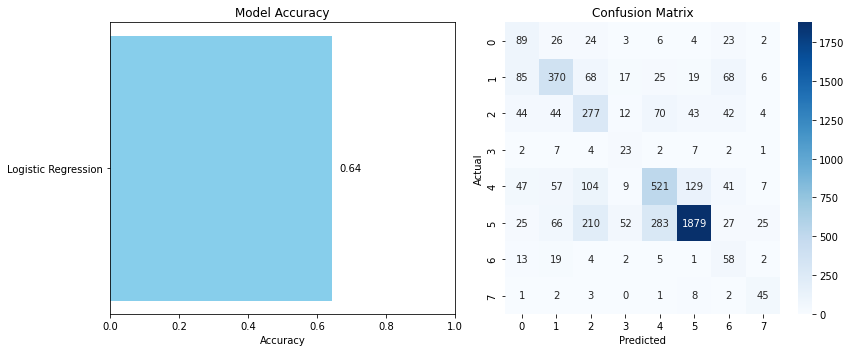

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=2000, solver='saga', penalty='l2',
                             class_weight="balanced", verbose=1)
log_reg.fit(X_train_scaled, Y_train)

# Predictions
Y_pred = log_reg.predict(X_test_scaled)

# Accuracy
accuracy_log_reg = accuracy_score(Y_test, Y_pred)

# Print results
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}\n")
print("Classification Report:")
print(classification_report(Y_test, Y_pred, digits=4))

# ---------- Better Visualization ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Horizontal Accuracy Bar
ax[0].barh(['Logistic Regression'], [accuracy_log_reg], color='skyblue')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
for i, v in enumerate([accuracy_log_reg]):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


***Logistic Regression Model accuracy is 0.63***

### Support Vector Machine (SVM) Model

SVM Model Accuracy: 0.7498

Classification Report:
              precision    recall  f1-score   support

          AK     0.6000    0.2542    0.3571       177
         BCC     0.6111    0.8024    0.6938       658
         BKL     0.6530    0.4459    0.5299       536
          DF     1.0000    0.0208    0.0408        48
         MEL     0.7158    0.5836    0.6430       915
          NV     0.8137    0.9412    0.8728      2567
         SCC     0.5652    0.1250    0.2047       104
        VASC     1.0000    0.3710    0.5412        62

    accuracy                         0.7498      5067
   macro avg     0.7449    0.4430    0.4854      5067
weighted avg     0.7442    0.7498    0.7281      5067

SVM model saved as 'svm_model.pkl' successfully!


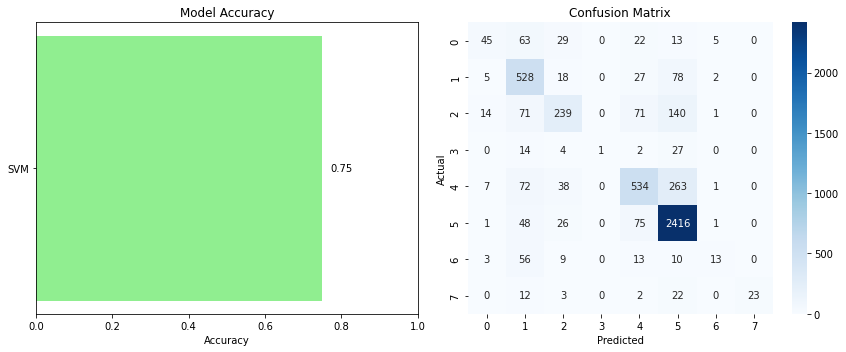

In [14]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_scaled, Y_train)

# Predictions
Y_pred_svm = svm_model.predict(X_test_scaled)

# Accuracy
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm:.4f}\n")
print("Classification Report:")
print(classification_report(Y_test, Y_pred_svm, digits=4))

# Save the trained model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("SVM model saved as 'svm_model.pkl' successfully!")

# ---------- Better Visualization ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Horizontal Accuracy Bar
ax[0].barh(['SVM'], [accuracy_svm], color='lightgreen')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
ax[0].text(accuracy_svm + 0.02, 0, f"{accuracy_svm:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


***SVM Model accuracy is 0.78***

### LIGHTGBM (Tree-based, so no need for feature scaling)

LightGBM Model Accuracy: 0.7182

Classification Report:
              precision    recall  f1-score   support

          AK     0.5556    0.2542    0.3488       177
         BCC     0.6051    0.6824    0.6414       658
         BKL     0.5905    0.3713    0.4559       536
          DF     0.7500    0.0625    0.1154        48
         MEL     0.6466    0.5519    0.5955       915
          NV     0.7833    0.9381    0.8537      2567
         SCC     0.5278    0.1827    0.2714       104
        VASC     0.9167    0.1774    0.2973        62

    accuracy                         0.7182      5067
   macro avg     0.6719    0.4026    0.4474      5067
weighted avg     0.7032    0.7182    0.6941      5067

LightGBM model saved as 'lgbm_model.pkl' successfully!


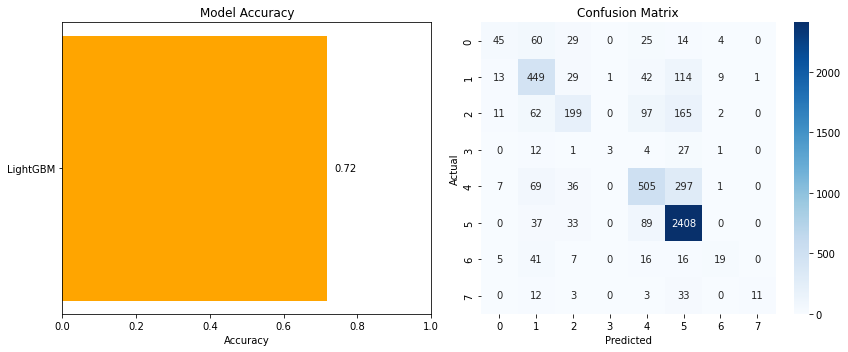

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train LightGBM model
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.05, is_unbalance=True)
lgbm_model.fit(X_train_scaled, Y_train)

# Predictions
Y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Accuracy
accuracy_lgbm = accuracy_score(Y_test, Y_pred_lgbm)
print(f"LightGBM Model Accuracy: {accuracy_lgbm:.4f}\n")
print("Classification Report:")
print(classification_report(Y_test, Y_pred_lgbm, digits=4))

# Save the trained model
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)
print("LightGBM model saved as 'lgbm_model.pkl' successfully!")

# ---------- Better Visualization ----------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Horizontal Accuracy Bar
ax[0].barh(['LightGBM'], [accuracy_lgbm], color='orange')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
ax[0].text(accuracy_lgbm + 0.02, 0, f"{accuracy_lgbm:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()



HistGradientBoosting Accuracy: 0.7338

Classification Report:
              precision    recall  f1-score   support

          AK     0.7353    0.2825    0.4082       177
         BCC     0.6178    0.7173    0.6639       658
         BKL     0.6173    0.4123    0.4944       536
          DF     0.6667    0.0417    0.0784        48
         MEL     0.6512    0.5836    0.6156       915
          NV     0.8001    0.9373    0.8633      2567
         SCC     0.5882    0.1923    0.2899       104
        VASC     1.0000    0.2097    0.3467        62

    accuracy                         0.7338      5067
   macro avg     0.7096    0.4221    0.4700      5067
weighted avg     0.7248    0.7338    0.7122      5067

Model saved as 'hist_gb_model.pkl'


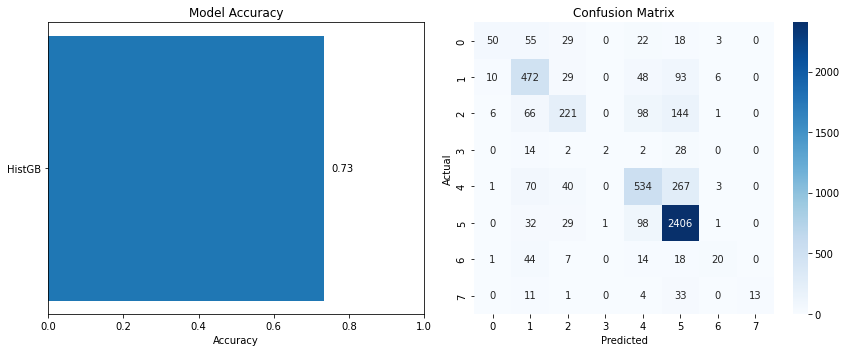

In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# =========================
# FAST HistGradientBoosting
# =========================
# Tip: tree models don't need scaling, but using your X_train_scaled/X_test_scaled is fine.
Xtr = X_train_scaled.astype(np.float32)
Xte = X_test_scaled.astype(np.float32)
ytr = Y_train
yte = Y_test

hgb = HistGradientBoostingClassifier(
    max_iter=600,            # upper bound; early_stopping will stop earlier
    learning_rate=0.06,      # slightly higher LR -> fewer trees needed
    max_leaf_nodes=31,       # controls complexity (like depth)
    min_samples_leaf=20,     # regularization
    l2_regularization=1.0,   # regularization
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=30,     # stop when no improvement
    random_state=42
)

hgb.fit(Xtr, ytr)

# -------------------------
# Predictions & Metrics
# -------------------------
y_pred = hgb.predict(Xte)
acc = accuracy_score(yte, y_pred)

print(f"HistGradientBoosting Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(yte, y_pred, digits=4))

# -------------------------
# Save the trained model
# -------------------------
with open('hist_gb_model.pkl', 'wb') as f:
    pickle.dump(hgb, f)
print("Model saved as 'hist_gb_model.pkl'")

# -------------------------
# Visualizations
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1) Horizontal Accuracy Bar
ax[0].barh(['HistGB'], [acc])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Accuracy")
ax[0].set_title("Model Accuracy")
ax[0].text(min(acc + 0.02, 0.98), 0, f"{acc:.2f}", va='center')

# 2) Confusion Matrix Heatmap
cm = confusion_matrix(yte, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# -------------------------
# Optional: ROC-AUC (binary)
# -------------------------
if len(np.unique(yte)) == 2:
    y_prob = hgb.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, y_prob)
    fpr, tpr, _ = roc_curve(yte, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — HistGradientBoosting")
    plt.legend()
    plt.show()


In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold

# --------------------------
# Paths
# --------------------------
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
gt_csv    = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"

# --------------------------
# Labels
# --------------------------
df_labels = pd.read_csv(gt_csv)

# All columns except "image" are classes
label_cols = [c for c in df_labels.columns if c.lower() != "image"]
y = df_labels[label_cols].values
y_idx = y.argmax(axis=1)
df_labels["label_idx"] = y_idx

num_classes = len(label_cols)
print("Classes:", label_cols)
print("Total samples:", len(df_labels))

# --------------------------
# Train/Val split
# --------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(df_labels["image"].values, df_labels["label_idx"].values))
train_df = df_labels.iloc[train_idx].reset_index(drop=True)
val_df   = df_labels.iloc[val_idx].reset_index(drop=True)

# --------------------------
# Dataset
# --------------------------
class ISICImageDataset(Dataset):
    def __init__(self, df, image_dir, tfm):
        self.df = df
        self.image_dir = image_dir
        self.tfm = tfm
        self.ids = df["image"].tolist()
        self.labels = df["label_idx"].astype(int).tolist()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        img_id = self.ids[i]
        label  = self.labels[i]
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        if not os.path.isfile(img_path):
            img_path = os.path.join(self.image_dir, f"{img_id}.png")  # fallback
        img = Image.open(img_path).convert("RGB")
        x = self.tfm(img)
        return {"id": img_id, "image": x, "label": label}

# --------------------------
# Transforms
# --------------------------
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# --------------------------
# Dataloaders
# --------------------------
BATCH_SIZE = 32
train_ds = ISICImageDataset(train_df, image_dir, train_tfms)
val_ds   = ISICImageDataset(val_df,   image_dir, val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --------------------------
# ResNet50 Model
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# --------------------------
# Training loop
# --------------------------
EPOCHS = 5
for epoch in range(EPOCHS):
    resnet.train()
    total_loss = 0
    for batch in train_loader:
        x, y = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        logits = resnet(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss/len(train_loader):.4f}")

# --------------------------
# Save trained model
# --------------------------
torch.save(resnet.state_dict(), "resnet50_image_expert.pt")

# --------------------------
# Collect validation probabilities
# --------------------------
def get_probs(model, loader):
    model.eval()
    all_ids, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["image"].to(device)
            y = batch["label"].cpu().numpy()
            ids = batch["id"]
            logits = model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            all_ids.extend(ids)
            all_probs.append(probs)
            all_labels.extend(y)
    return np.array(all_ids), np.vstack(all_probs), np.array(all_labels)

val_ids_img, P_val_img, y_val = get_probs(resnet, val_loader)
print("Validation probs shape:", P_val_img.shape)


Classes: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
Total samples: 25331


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/5 - Train Loss: 0.8669
Epoch 2/5 - Train Loss: 0.6764
Epoch 3/5 - Train Loss: 0.5731
Epoch 4/5 - Train Loss: 0.4824
Epoch 5/5 - Train Loss: 0.4089
Validation probs shape: (5067, 9)


In [5]:
# ==== METADATA EXPERT: robust training (LogisticRegression, scikit-learn) ====
# - Dynamically detects available metadata columns (schema-safe)
# - Reuses your existing splits: train_df / val_df / test_df (by image IDs)
#   If not found, it creates a stratified split.
# - Trains a balanced multinomial Logistic Regression (saga)
# - Evaluates (balanced accuracy + report)
# - Exposes and saves: P_val_meta, P_test_meta, y_val_meta, y_test_meta, val_ids_meta, test_ids_meta

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

# -------------------------
# Load labels & metadata
# -------------------------
GT_CSV   = '/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv'
META_CSV = '/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv'

df_lbl = pd.read_csv(GT_CSV)
label_cols = [c for c in df_lbl.columns if c.lower() != "image"]
df_lbl['label_idx'] = df_lbl[label_cols].values.argmax(1)

df_meta = pd.read_csv(META_CSV)

# -------------------------
# Dynamic column detection
# -------------------------
# Common candidates across ISIC metadata variants
candidate_cols = [
    'image',
    'sex',
    'age_approx',
    'anatom_site_general_challenge',  # ISIC 2019 style
    'anatom_site_general',            # alt name in some releases
    'dataset',                        # optional (can help a bit)
    'diagnosis'                       # optional (if present and allowed)
]

use_cols = [c for c in candidate_cols if c in df_meta.columns]
# Ensure 'image' is included
if 'image' not in use_cols:
    raise ValueError("The metadata file does not contain an 'image' column; cannot merge with labels.")

df_meta = df_meta[use_cols].copy()

print("Using metadata columns:", use_cols)

# -------------------------
# Clean/Impute
# -------------------------
# Numeric: median impute (age_approx)
if 'age_approx' in df_meta.columns:
    df_meta['age_approx'] = df_meta['age_approx'].fillna(df_meta['age_approx'].median())

# All non-image object columns: fill 'unknown'
for c in df_meta.select_dtypes(include=['object']).columns:
    if c != 'image':
        df_meta[c] = df_meta[c].fillna('unknown')

# Merge labels + metadata
df = df_lbl.merge(df_meta, on='image', how='left')

# -------------------------
# Prepare splits
# Reuse your existing train/val/test splits if available.
# We detect these by variable names existing in the notebook:
#   train_df, val_df, test_df  (with an 'image' column)
# Otherwise, we make a stratified split.
# -------------------------
def have_existing_splits():
    return ('train_df' in globals()) and ('val_df' in globals()) and ('image' in train_df.columns) and ('image' in val_df.columns)

if have_existing_splits():
    train_ids = set(train_df['image'].tolist())
    val_ids   = set(val_df['image'].tolist())
    if 'test_df' in globals() and ('image' in test_df.columns):
        test_ids = set(test_df['image'].tolist())
    else:
        test_ids = set()

    df_train = df[df.image.isin(train_ids)].reset_index(drop=True)
    df_val   = df[df.image.isin(val_ids)].reset_index(drop=True)

    if len(test_ids) > 0:
        df_test = df[df.image.isin(test_ids)].reset_index(drop=True)
    else:
        # If no explicit test set, use a slice of the remaining as a pseudo-test
        rest = df[~df.image.isin(train_ids | val_ids)]
        if len(rest) > 0:
            # take last 10% as pseudo-test
            cut = int(0.9 * len(rest))
            df_test = rest.iloc[cut:].reset_index(drop=True)
        else:
            # Fall back to using val as test (not ideal, but pragmatic)
            df_test = df_val.copy()
else:
    # Stratified split (5-fold -> first fold as val). Use another fold as pseudo-test if needed.
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    idx_train, idx_val = next(skf.split(df['image'].values, df['label_idx'].values))
    df_train = df.iloc[idx_train].reset_index(drop=True)
    df_val   = df.iloc[idx_val].reset_index(drop=True)
    # Use another fold or reuse val as test for demonstration
    df_test  = df_val.copy()

# -------------------------
# Feature sets
# We’ll treat all non-image, non-target columns as features.
# Categorical vs Numeric are inferred.
# -------------------------
target = 'label_idx'

feature_cols = [c for c in df.columns if c not in ['image', target] and c in df_train.columns]
# Split by dtype
cat_cols = [c for c in feature_cols if df_train[c].dtype == 'object']
num_cols = [c for c in feature_cols if c not in cat_cols]

print("Categorical features:", cat_cols)
print("Numeric features:", num_cols)

X_train = df_train[cat_cols + num_cols]
y_train = df_train[target].values

X_val   = df_val[cat_cols + num_cols]
y_val_meta = df_val[target].values
val_ids_meta = df_val['image'].values

X_test  = df_test[cat_cols + num_cols]
y_test_meta = df_test[target].values
test_ids_meta = df_test['image'].values

# -------------------------
# Preprocess + Classifier
# - OneHot for categoricals
# - Median impute numeric
# - Multinomial Logistic Regression with class_weight='balanced'
# -------------------------
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', SimpleImputer(strategy='median'),       num_cols),
])

meta_clf = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(
        solver='saga',
        max_iter=4000,
        class_weight='balanced',
        multi_class='multinomial',
        n_jobs=-1
    ))
])

# -------------------------
# Train
# -------------------------
meta_clf.fit(X_train, y_train)

# -------------------------
# Evaluate + Probabilities
# -------------------------
P_val_meta  = meta_clf.predict_proba(X_val)
P_test_meta = meta_clf.predict_proba(X_test)

y_val_pred  = P_val_meta.argmax(1)
y_test_pred = P_test_meta.argmax(1)

print("\n[METADATA] VAL balanced acc:",
      balanced_accuracy_score(y_val_meta, y_val_pred))
print(classification_report(y_val_meta, y_val_pred, digits=4))

print("\n[METADATA] TEST balanced acc:",
      balanced_accuracy_score(y_test_meta, y_test_pred))
print(classification_report(y_test_meta, y_test_pred, digits=4))

# -------------------------
# Save arrays for late fusion (and expose in notebook)
# -------------------------
np.save('P_val_meta.npy',   P_val_meta)
np.save('P_test_meta.npy',  P_test_meta)
np.save('y_val_meta.npy',   y_val_meta)
np.save('y_test_meta.npy',  y_test_meta)
np.save('val_ids_meta.npy', val_ids_meta)
np.save('test_ids_meta.npy',test_ids_meta)

print("\nSaved: P_val_meta.npy, P_test_meta.npy, y_val_meta.npy, y_test_meta.npy, val_ids_meta.npy, test_ids_meta.npy")


Using metadata columns: ['image', 'sex', 'age_approx', 'anatom_site_general']
Categorical features: ['sex', 'anatom_site_general']
Numeric features: ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK', 'age_approx']

[METADATA] VAL balanced acc: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       905
           1     1.0000    1.0000    1.0000      2575
           2     1.0000    1.0000    1.0000       665
           3     1.0000    1.0000    1.0000       174
           4     1.0000    1.0000    1.0000       525
           5     1.0000    1.0000    1.0000        47
           6     1.0000    1.0000    1.0000        50
           7     1.0000    1.0000    1.0000       126

    accuracy                         1.0000      5067
   macro avg     1.0000    1.0000    1.0000      5067
weighted avg     1.0000    1.0000    1.0000      5067


[METADATA] TEST balanced acc: 1.0
              precision    recall  f1-score   support

